In [ ]:
  !pip install mediapipe
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 11.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d rakibuleceruet/drowsiness-prediction-dataset


drowsiness-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

'0 FaceImages'	    drowsiness-prediction-dataset.zip	  haarcascade_frontalface_default.xml.1
'Active Subjects'  'Fatigue Subjects'			  kaggle.json
 detection.ipynb    fire-alarm-9677.mp3			  my_model.h5
 detection.py	    haarcascade_frontalface_default.xml


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  drowsiness-prediction-dataset.zip
replace 0 FaceImages/Active Subjects/image_0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
A

n


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

FileExistsError: ignored

In [ ]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [ ]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt

     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [ ]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2023-10-25 19:44:32--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.04s   

2023-10-25 19:44:32 (21.2 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [ ]:
def face_for_yawn(direc='/content/gdrive/MyDrive/Kaggle/0 FaceImages', face_cas_path="haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)

        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0


In [ ]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3869


In [ ]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3749


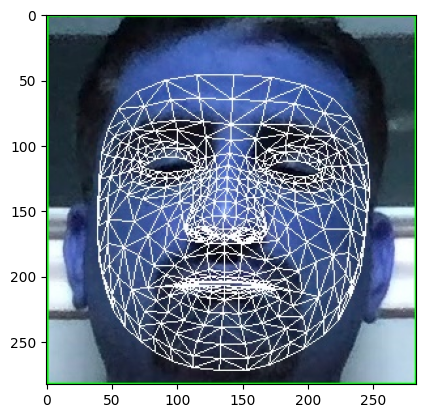

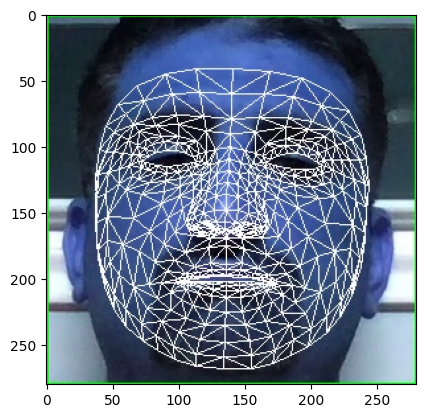

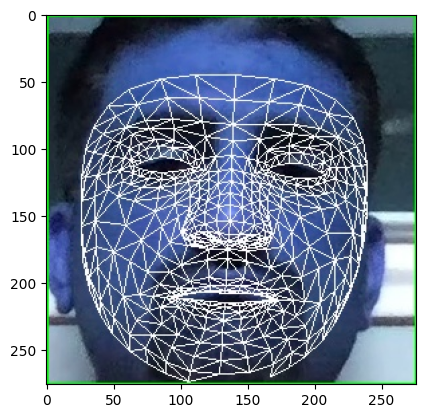

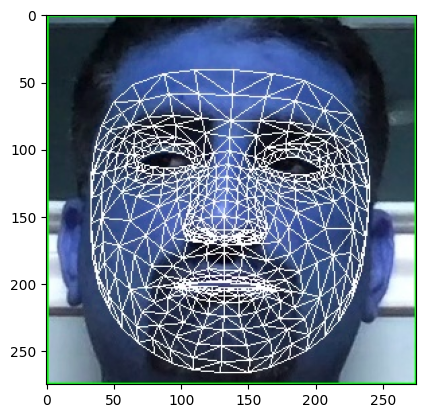

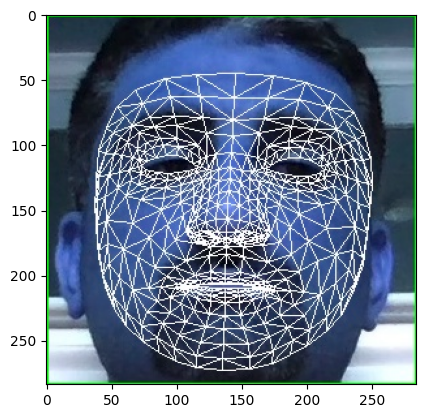

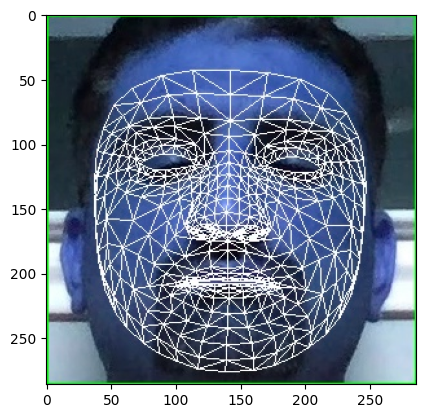

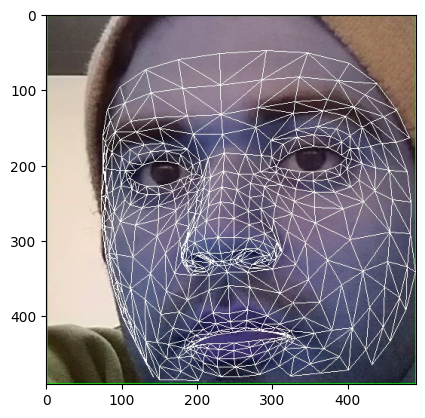

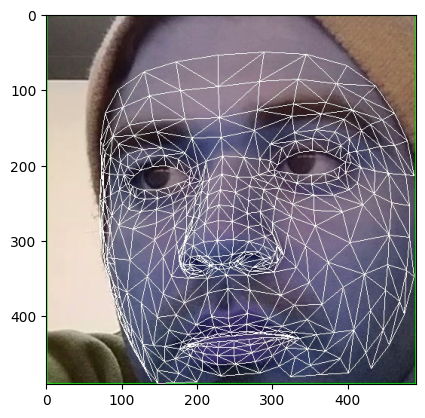

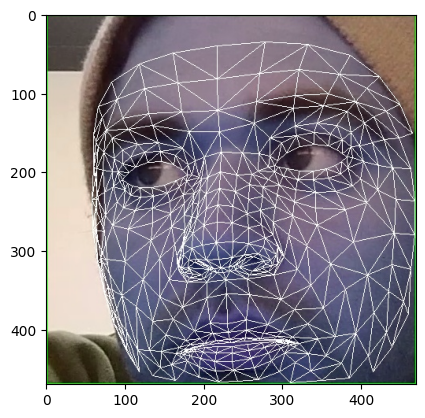

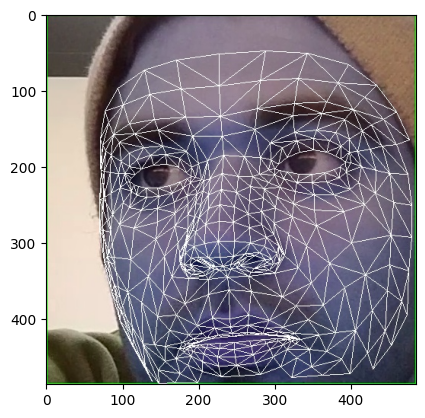

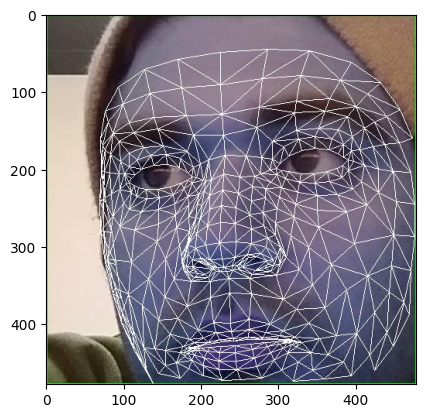

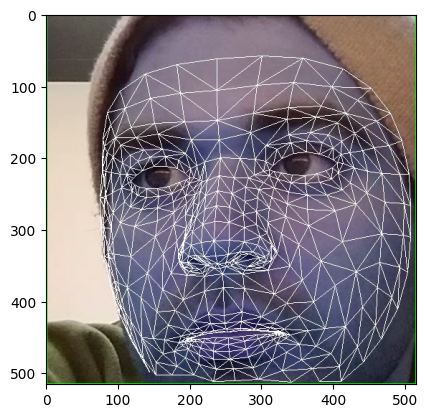

In [ ]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

In [ ]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()


0
1


In [ ]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)


In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

1524

In [ ]:
len(X_train)

6094

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
# Model Elsafty 1
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# Note the input shape is the desired size of the image 145 x 145 with 3 bytes color
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 143, 143, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 32)        12832     
                                                                 
 batch_normalization_1 (Bat  (None, 67, 67, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
history = model.fit(train_generator, epochs=1, validation_data=test_generator)

Epoch 1/10
191/191 [==============================] - 326s 2s/step - loss: 0.4582 - accuracy: 0.7726 - val_loss: 3.5350 - val_accuracy: 0.4823
Epoch 2/10
191/191 [==============================] - 324s 2s/step - loss: 0.3970 - accuracy: 0.8075 - val_loss: 0.6286 - val_accuracy: 0.7139
Epoch 3/10
191/191 [==============================] - 330s 2s/step - loss: 0.3791 - accuracy: 0.8180 - val_loss: 0.7876 - val_accuracy: 0.5584
Epoch 4/10
191/191 [==============================] - 328s 2s/step - loss: 0.3457 - accuracy: 0.8446 - val_loss: 0.5436 - val_accuracy: 0.7054
Epoch 5/10
191/191 [==============================] - 325s 2s/step - loss: 0.2981 - accuracy: 0.8694 - val_loss: 0.3677 - val_accuracy: 0.8576
Epoch 6/10
191/191 [==============================] - 331s 2s/step - loss: 0.2711 - accuracy: 0.8868 - val_loss: 0.4032 - val_accuracy: 0.7881
Epoch 7/10
191/191 [==============================] - 332s 2s/step - loss: 0.2438 - accuracy: 0.8960 - val_loss: 0.2422 - val_accuracy: 0.8957

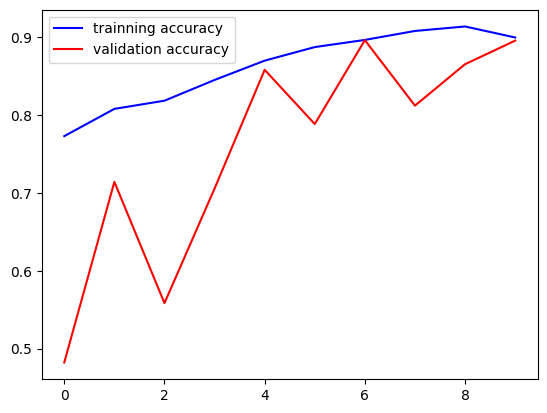

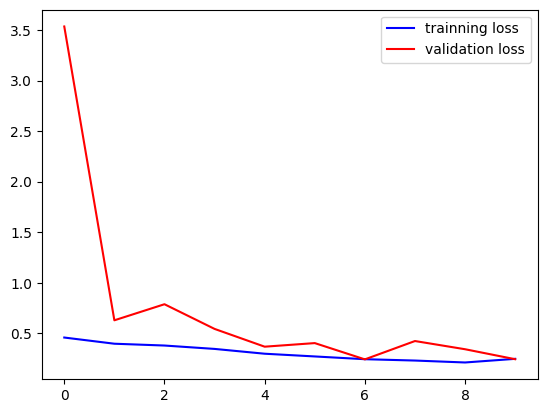

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
48/48 [==============================] - 18s 370ms/step - loss: 0.2438 - accuracy: 0.8950


{'loss': 0.24379600584506989, 'accuracy': 0.8950130939483643}

In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


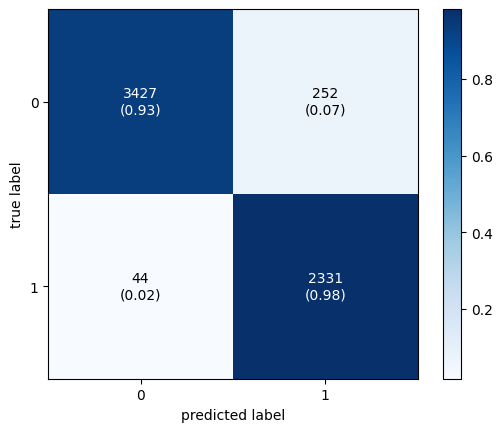

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model
from keras.utils import plot_model

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

ModuleNotFoundError: ignored

In [ ]:
pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=08d9e1fb1030063ae2d82532cfc71231c735eab9d08f7f697982577e2beeb4fb
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound


In [ ]:
import cv2
import numpy as np

from keras.models import load_model
from keras.preprocessing.image import img_to_array
from playsound import playsound
from threading import Thread


def start_alarm(sound):
    """Play the alarm sound"""
    playsound('/content/gdrive/MyDrive/Kaggle/fire-alarm-9677.mp3')


classes = ['Closed', 'Open']
face_cascade = cv2.CascadeClassifier("data/haarcascade_frontalface_default.xml")
left_eye_cascade = cv2.CascadeClassifier("data/haarcascade_lefteye_2splits.xml")
right_eye_cascade = cv2.CascadeClassifier("data/haarcascade_righteye_2splits.xml")
cap = cv2.VideoCapture(0)
model = load_model("my_model.h5")
count = 0
alarm_on = False
alarm_sound = "/content/gdrive/MyDrive/Kaggle/fire-alarm-9677.mp3"
status1 = ''
status2 = ''

while True:
    _, frame = cap.read()
    height = frame.shape[0]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        left_eye = left_eye_cascade.detectMultiScale(roi_gray)
        right_eye = right_eye_cascade.detectMultiScale(roi_gray)
        for (x1, y1, w1, h1) in left_eye:
            cv2.rectangle(roi_color, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 1)
            eye1 = roi_color[y1:y1+h1, x1:x1+w1]
            eye1 = cv2.resize(eye1, (145, 145))
            eye1 = eye1.astype('float') / 255.0
            eye1 = img_to_array(eye1)
            eye1 = np.expand_dims(eye1, axis=0)
            pred1 = model.predict(eye1)
            status1=np.argmax(pred1)
            #print(status1)
            #status1 = classes[pred1.argmax(axis=-1)[0]]
            break

        for (x2, y2, w2, h2) in right_eye:
            cv2.rectangle(roi_color, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 1)
            eye2 = roi_color[y2:y2 + h2, x2:x2 + w2]
            eye2 = cv2.resize(eye2, (145, 145))
            eye2 = eye2.astype('float') / 255.0
            eye2 = img_to_array(eye2)
            eye2 = np.expand_dims(eye2, axis=0)
            pred2 = model.predict(eye2)
            status2=np.argmax(pred2)
            #print(status2)
            #status2 = classes[pred2.argmax(axis=-1)[0]]
            break

        # If the eyes are closed, start counting
        if status1 == 2 and status2 == 2:
        #if pred1 == 2 and pred2 == 2:
            count += 1
            cv2.putText(frame, "Eyes Closed, Frame count: " + str(count), (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1)
            # if eyes are closed for 10 consecutive frames, start the alarm
            if count >= 10:
                cv2.putText(frame, "Drowsiness Alert!!!", (100, height-20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
                if not alarm_on:
                    alarm_on = True
                    # play the alarm sound in a new thread
                    t = Thread(target=start_alarm, args=(alarm_sound,))
                    t.daemon = True
                    t.start()
        else:
            cv2.putText(frame, "Eyes Open", (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1)
            count = 0
            alarm_on = False

    cv2.imshow("Drowsiness Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

error: ignored